In [70]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [71]:
read_file = pd.read_csv ('C:/Users/stat_pc/Desktop/深度學習/Lab08/train.txt')
read_file.to_csv ('C:/Users/stat_pc/Desktop/深度學習/Lab08/train.csv', index=None)
read_file = pd.read_csv ('C:/Users/stat_pc/Desktop/深度學習/Lab08/test.txt')
read_file.to_csv ('C:/Users/stat_pc/Desktop/深度學習/Lab08/test.csv', index=None)

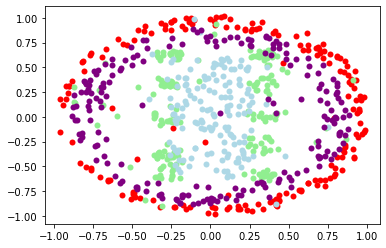

In [72]:
import csv
file = open('C:/Users/stat_pc/Desktop/深度學習/Lab08/train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_train = np.ndarray((0, 2))
y_train = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X_train = np.vstack((X_train, np.array(row[0:2])))
  y_train = np.append(y_train, y_mapping[row[2]])
X_train = X_train.astype(np.float)
y_train = y_train.astype(np.float)
file.close()

file = open('C:/Users/stat_pc/Desktop/深度學習/Lab08/test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_test = np.ndarray((0, 2))
y_test = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X_test = np.vstack((X_test, np.array(row[0:2])))
  y_test = np.append(y_test, y_mapping[row[2]])
X_test = X_test.astype(np.float)
y_test = y_test.astype(np.float)
file.close()

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train[y_train == 2, 0], X_train[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label='Sue', c='purple', linewidths=0)

# 用Logistic Regression、Decision Tree、KNN 做 Voting 
# accuracy = 0.7783783783783784 

In [73]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

In [74]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.275 (+/- 0.038)
DecisionTree: 0.505 (+/- 0.034)
KNN: 0.821 (+/- 0.053)


In [75]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.824 (+/- 0.053)
(0, 2, 1): 0.759 (+/- 0.043)
(1, 0, 2): 0.820 (+/- 0.052)
(1, 2, 0): 0.505 (+/- 0.034)
(2, 0, 1): 0.812 (+/- 0.065)
(2, 1, 0): 0.495 (+/- 0.042)

Best (0, 1, 2): 0.824


In [76]:
clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[0,1,2])
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7783783783783784

# Bagging accuracy = 0.811

In [77]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

In [78]:
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[Bagging] accuracy-train = 0.991, accuracy-test = 0.811


# Boosting
# AdaBoost  accuracy = 0.665

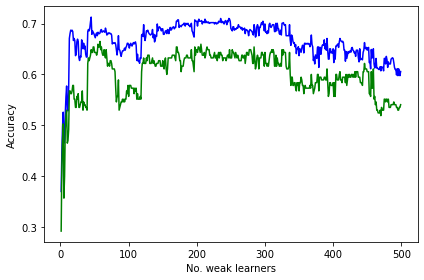

In [79]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
# adaboost
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))

plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

In [80]:
ada16 = AdaBoostClassifier(base_estimator=tree, n_estimators=ada_test.index(max(ada_test))+1)
ada16.fit(X_train, y_train)
y_train_pred = ada16.predict(X_train)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[AdaBoost] accuracy-train = 0.682, accuracy-test = 0.665


## Use GridSearch to  fine tune Adaboost
## We get the best Adaboost accuarcy = 0.7945945945945946, which is better than the original Adaboost 

In [69]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
from sklearn.metrics import confusion_matrix
parameters_for_testing = {
    'base_estimator__max_depth':[1,2,5,7,10,15],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[150,200,300,400,500,600],
    'random_state':[0]
}

adaboost = AdaBoostClassifier(base_estimator=tree)

Grid = GridSearchCV(estimator = adaboost, param_grid = parameters_for_testing, scoring='accuracy',verbose=2,n_jobs=-1)
Grid.fit(X_train,y_train)

pred = Grid.predict(X_test)

print('accuarcy')
print(accuracy_score(y_test, pred))
print('best params')
print (Grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   54.5s finished


accuarcy
0.7945945945945946
best params
{'base_estimator__max_depth': 5, 'learning_rate': 0.001, 'n_estimators': 150, 'random_state': 0}


# Summary 
## 我們嘗試用voting、bagging 和 boosting（Adaboost）的方法，結果發現bagging的accuarcy較高。
## 而Adaboost的accuarcy一開始較低，但經過GridSearch後，accuarcy表現明顯提升，其中一個參數的改變就是decision tree的depths變深，推測部分原因是因為decision tree的depths變深，使得Adaboost的accuarcy表現變好。